# Predire la presenza o assenza del diabete nel paziente

**Programmazione di Applicazioni Data Intensive**

Progetto preliminare all'esame

A.a 2020-2021

Sofia Belloni - sofia.belloni@studio.unibo.it


## Descrizione del problema

Si vuole realizzare un modello che consenta di predire se un paziente ha o meno il diabete, sulla base di determinate misurazioni diagnostiche incluse nel dataset analizzato.

Il dataset in esame, ottenuto da [Kaggle](https://www.kaggle.com/vikasukani/diabetes-data-set), contiene informazioni sullo stato di salute di 2000 pazienti.

**Caricamento Librerie**

Per prima cosa importiamo le librerie principali usando i loro alias convenzionali, in particolare importiamo:
*   matplotlib e seaborn per creare grafici
*   NumPy per creare e operare su array a N dimensioni
*   pandas per caricare e manipolare dati tabulari

Eventuali ulteriori librerie verranno importate in seguito quando necessario.

In [599]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline

**Caricamento dati** 

Il dataset è stato successivamente caricato su BitBucket in modo da renderlo sempre recuperabile. 

Carichiamo quindi il dataset e riportiamo il numero di istanze non nulle, il tipo delle feature che compongono i dati raccolti nel dataset e le dimensioni di questo in memoria, osservando come il consumo di memoria sia irrisorio.

In [600]:
URL = "https://bitbucket.org/sofiabelloni/progetto_dia/raw/2761cb56a075d0d780453980c7c067ea886892a5/diabetes-dataset.csv"
data = pd.read_csv(URL, sep=",")

In [601]:
data.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 9 entries, Pregnancies to Outcome
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


**Significato delle feature**

In [602]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


Come riportato su Kaggle, nello specifico le feature sono:

*   *Pregnancies* (Gravidanze): Numero di gravidanze
*   *Glucose* (Glucosio): concentrazione plasmatica di glucosio a 2 ore in un test orale di tolleranza al glucosio
*   *BloodPressure* (Pressione sanguigna): Pressione sanguigna diastolica (mmHg)
*   *SkinThickness* (Spessore della pelle): Spessore della piega cutanea del tricipite (mm)
*   *Insulin* (Insulina): insulina sierica (mu U/ml)
*   *BMI*: Indice di massa corporea (peso in kg/(altezza in m)^2)
*   *DiabetesPedigreeFunction*: Funzione che valuta la probabilità di diabete in base alla storia familiare
*   *Age*: Età del paziente
*   *Outcome* (Risultato): indica la presenza (1) o assenza (0) del diabete

La variabile target è *Outcome* che è binaria: come sopra specificato, infatti, vale 1 se il paziente ha il diabete, in caso contrario assume valore 0.



## Analisi esplorativa dei dati


**Rilevazione di valori mancanti** 

Osserviamo se nel dataset sono presenti valori nulli: in questo caso non sono presenti per cui non è necessario trattarli.

In [603]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

**Analisi dei dati** 

Procediamo con l'analisi dei dati, osservandone i principali parametri quali media, deviazione standard, quartili, minimo e massimo.

In [604]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


Per poter meglio evidenziari le due classi (presenza o assenza del diabete), definiamo un dizionario che associ un colore a ciascuna classe.

In particolare, creiamo un dizionario che associa al valore 0 il colore verde e al valore 1 il colore rosso.

Successivamente, con il metodo *map*, convertiamo ciascun elemento in una serie secondo il dizionario dato, ottenendo così una serie di valori "green" e "red".

In [605]:
diabetes_presence_color = "red"
diabetes_absence_color = "green"

diagnosis_colors = [diabetes_absence_color, diabetes_presence_color]
diagnosis_color_map = {0: diabetes_absence_color, 1: diabetes_presence_color}
diagnosis_colors_values = data["Outcome"].map(diagnosis_color_map)
diagnosis_colors_values.head()

0      red
1    green
2      red
3      red
4    green
Name: Outcome, dtype: object

Rappresentiamo quindi in un grafico i valori della variabile target. 
Dal grafico a torta è possibile notare come i valori di *Outcome* non siano molto bilanciati, in quanto circa 2/3 dei pazienti non hanno il diabete. Questo potrebbe essere un problema nella fase di modellazione e valutazione del modello.

0    1316
1     684
Name: Outcome, dtype: int64


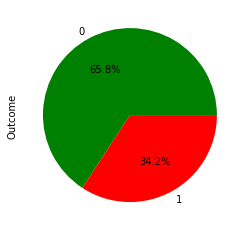

In [606]:
print(data["Outcome"].value_counts())
data['Outcome'].value_counts().plot.pie(autopct='%1.1f%%', colors=diagnosis_colors)

Dalla descrizione generale del Dataset si può notare come l'età dei paziente varia tra un minimo di 21 anni ed un massimo di 81. 

Utilizziamo la funzione *cut* di Pandas per osservare la distribuzione dei valori dividendo l'intervallo in 6 fasce di uguale ampiezza.

In questo modo è possibile notare come la maggior parte dei pazienti abbia un'età compresa tra i 21 e i 31 anni.

In [607]:
pd.cut(data["Age"], 6).value_counts()

(20.94, 31.0]    1164
(31.0, 41.0]      396
(41.0, 51.0]      258
(51.0, 61.0]      108
(61.0, 71.0]       68
(71.0, 81.0]        6
Name: Age, dtype: int64

Riportiamo ora in un istogramma i valori di tutte le misurazioni diagnostiche del dataset per meglio comprendere le caratteristiche dei pazienti a cui si fa riferimento.

Text(0.5, 0, 'years')

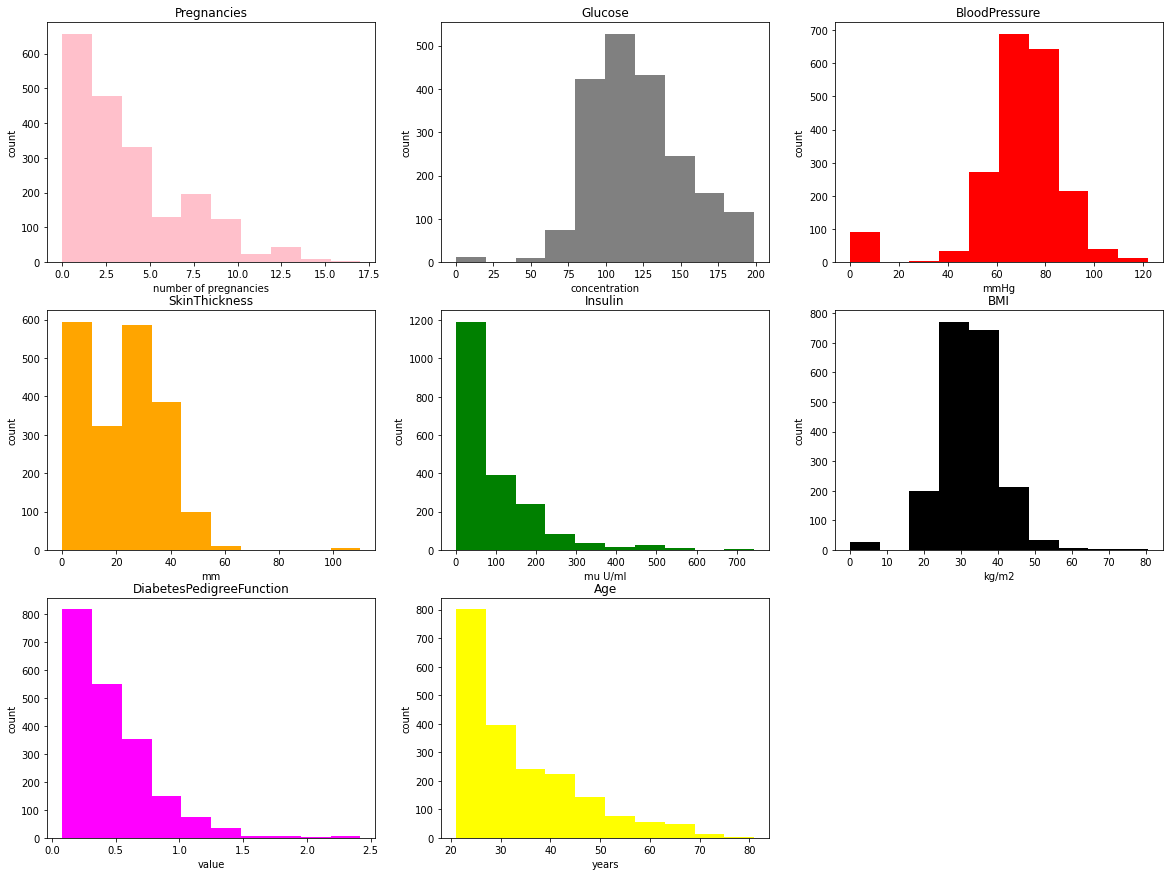

In [608]:
plt.figure(figsize=(20, 15))

plt.subplot(3, 3, 1)
plt.title('Pregnancies')
plt.hist(data['Pregnancies'], label="Pregnancies", color='pink')
plt.ylabel('count')
plt.xlabel('number of pregnancies')

plt.subplot(3, 3, 2)
plt.title('Glucose')
plt.hist(data['Glucose'], label="Glucose", color="gray")
plt.ylabel('count')
plt.xlabel('concentration')

plt.subplot(3, 3, 3)
plt.title('BloodPressure')
plt.hist(data['BloodPressure'], label="BloodPressure", color="red")
plt.ylabel('count')
plt.xlabel('mmHg')

plt.subplot(3, 3, 4)
plt.title('SkinThickness')
plt.hist(data['SkinThickness'], label="SkinThickness", color="orange")
plt.ylabel('count')
plt.xlabel('mm')

plt.subplot(3, 3, 5)
plt.title('Insulin')
plt.hist(data['Insulin'], label="Insulin", color="green")
plt.ylabel('count')
plt.xlabel('mu U/ml')

plt.subplot(3, 3, 6)
plt.title('BMI')
plt.hist(data['BMI'], label="BMI", color="black")
plt.ylabel('count')
plt.xlabel('kg/m2')

plt.subplot(3, 3, 7)
plt.title('DiabetesPedigreeFunction')
plt.hist(data['DiabetesPedigreeFunction'], label="DiabetesPedigreeFunction", color="magenta")
plt.ylabel('count')
plt.xlabel('value')

plt.subplot(3, 3, 8)
plt.title('Age')
plt.hist(data['Age'], label="Age", color="yellow")
plt.ylabel('count')
plt.xlabel('years')


Osserviamo quindi ad esempio che la maggior parte dei pazienti:

*   Ha avuto meno di 2 gravidanze
*   Ha un indice di massa corporea intorno a 30 kg/m2
*   Ha meno di 30 anni
*   Ha una bassa probabilità del diabete in base alla storia familiare

**Correlazione tra feature**

Osserviamo ora nei seguenti grafici a barre la correlazioni tra la presenza del diabete e le diverse misurazioni diagnostiche del dataset.

Text(0.5, 0, '')

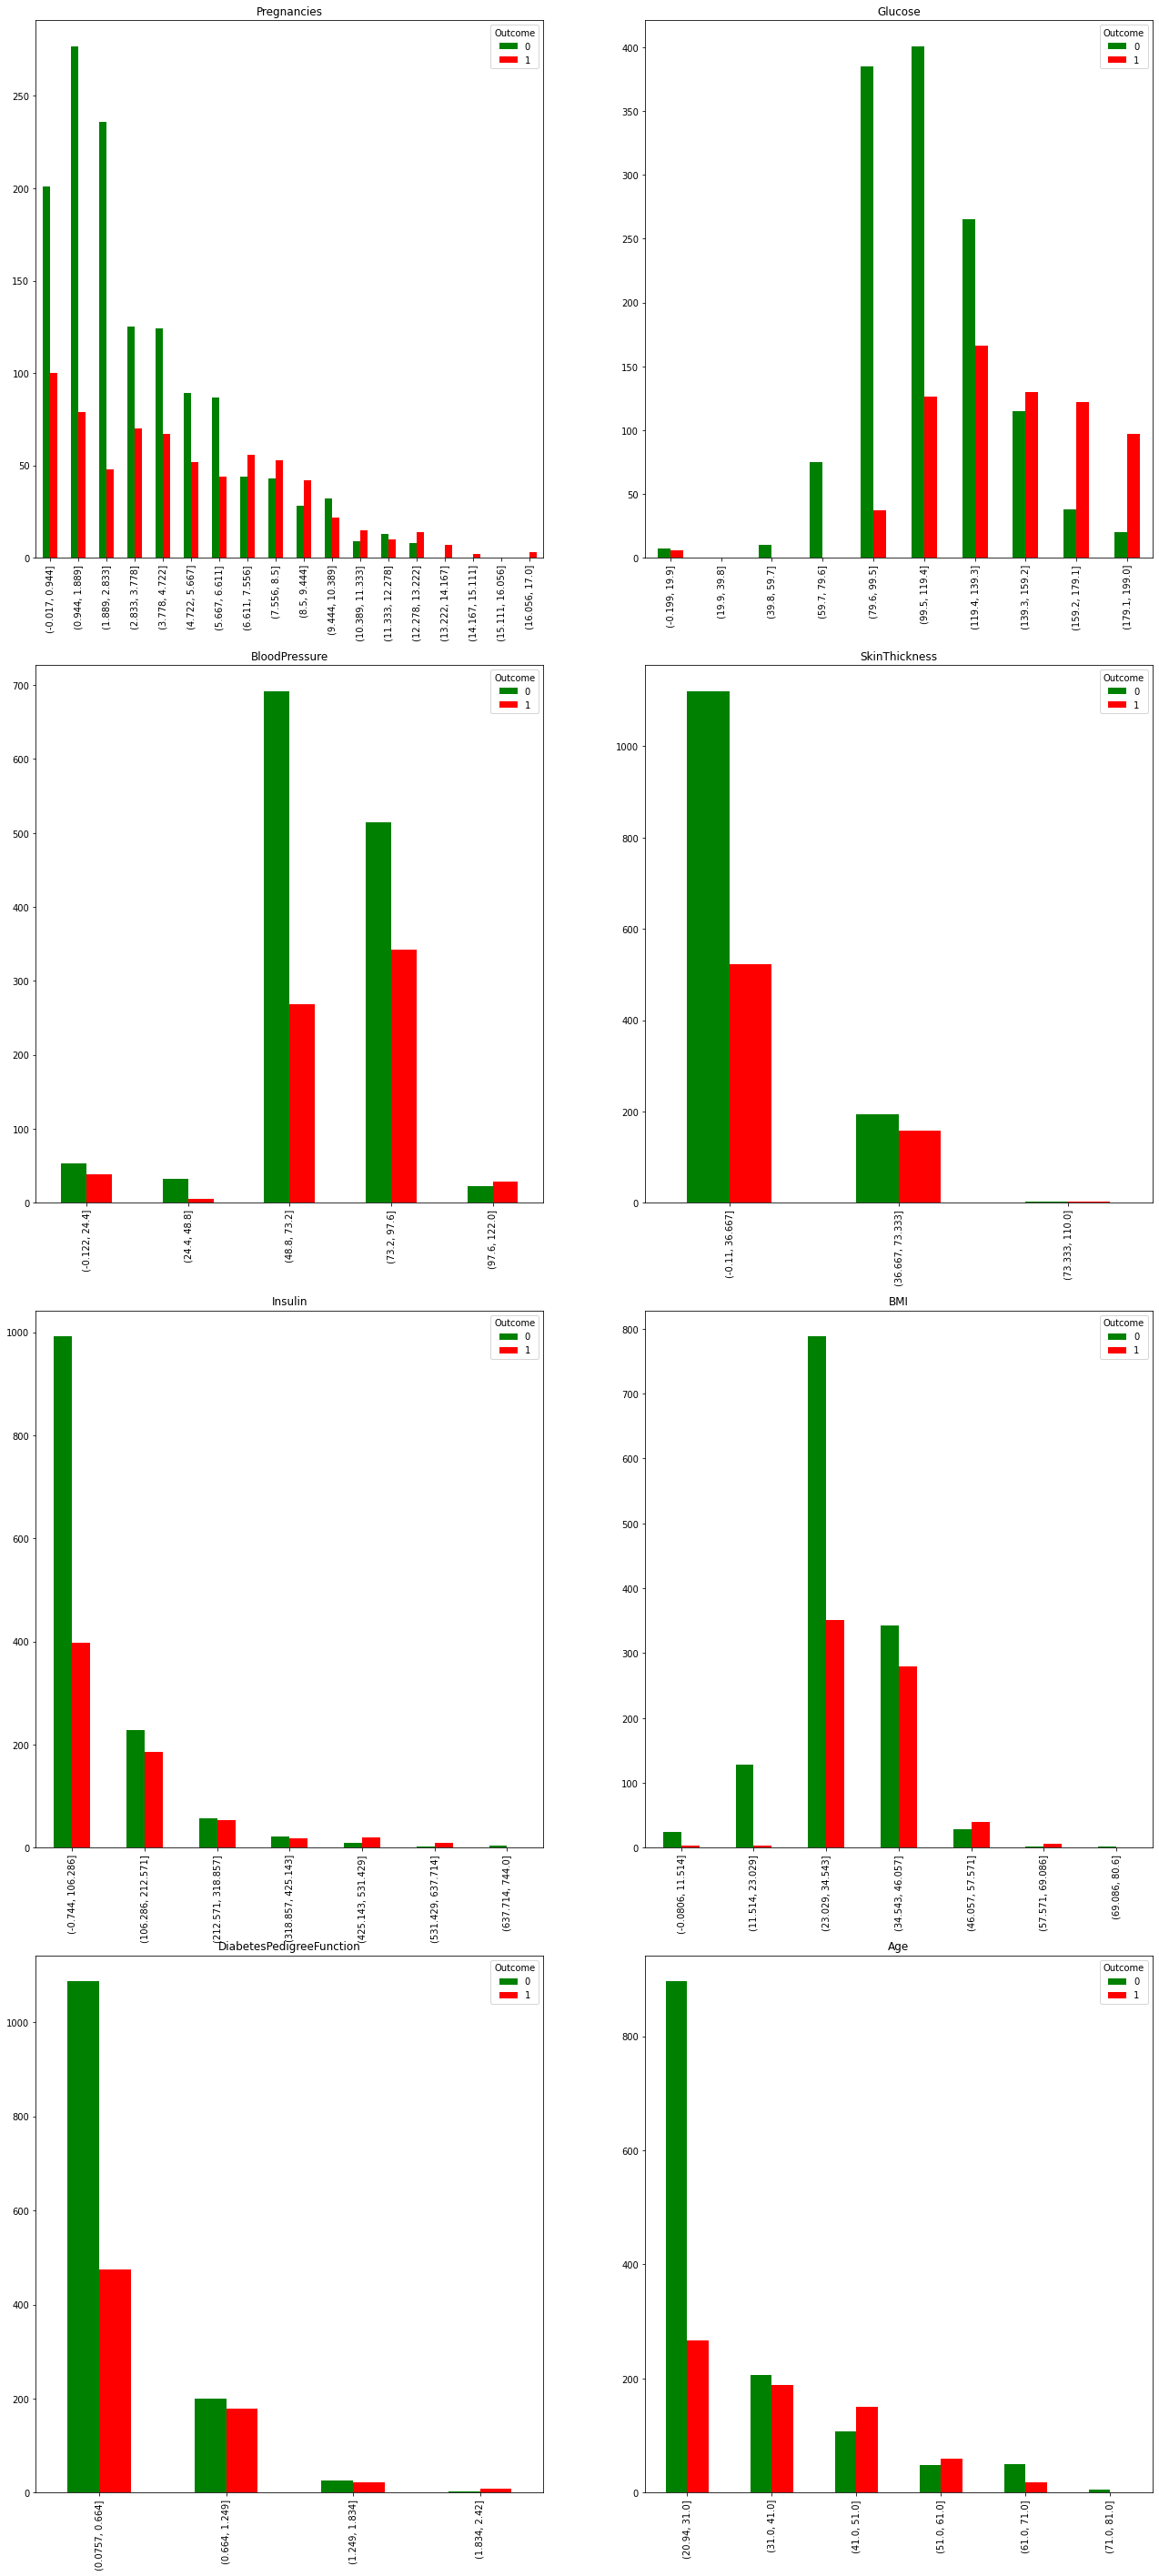

In [609]:
fig, axes = plt.subplots(nrows=4, ncols=2, sharex=False, sharey=False, figsize=(22, 50))
data.groupby([pd.cut(data["Pregnancies"], bins=18), "Outcome"]).size().unstack("Outcome").plot.bar(stacked=False, color=diagnosis_colors, ax=axes[0, 0])
data.groupby([pd.cut(data["Glucose"], bins=10), "Outcome"]).size().unstack("Outcome").plot.bar(stacked=False, color=diagnosis_colors, ax=axes[0, 1])
data.groupby([pd.cut(data["BloodPressure"], bins=5), "Outcome"]).size().unstack("Outcome").plot.bar(stacked=False, color=diagnosis_colors, ax=axes[1, 0])
data.groupby([pd.cut(data["SkinThickness"], bins=3), "Outcome"]).size().unstack("Outcome").plot.bar(stacked=False, color=diagnosis_colors, ax=axes[1, 1])
data.groupby([pd.cut(data["Insulin"], bins=7), "Outcome"]).size().unstack("Outcome").plot.bar(stacked=False, color=diagnosis_colors, ax=axes[2, 0])
data.groupby([pd.cut(data["BMI"], bins=7), "Outcome"]).size().unstack("Outcome").plot.bar(stacked=False, color=diagnosis_colors, ax=axes[2, 1])
data.groupby([pd.cut(data["DiabetesPedigreeFunction"], bins=4), "Outcome"]).size().unstack("Outcome").plot.bar(stacked=False, color=diagnosis_colors, ax=axes[3, 0])
data.groupby([pd.cut(data["Age"], bins=6), "Outcome"]).size().unstack("Outcome").plot.bar(stacked=False, color=diagnosis_colors, ax=axes[3, 1])

axes[0, 0].set_title("Pregnancies")
axes[0, 1].set_title("Glucose")
axes[1, 0].set_title("BloodPressure")
axes[1, 1].set_title("SkinThickness")
axes[2, 0].set_title("Insulin")
axes[2, 1].set_title("BMI")
axes[3, 0].set_title("DiabetesPedigreeFunction")
axes[3, 1].set_title("Age")

axes[0, 0].set_xlabel("")
axes[0, 1].set_xlabel("")
axes[1, 0].set_xlabel("")
axes[1, 1].set_xlabel("")
axes[2, 0].set_xlabel("")
axes[2, 1].set_xlabel("")
axes[3, 0].set_xlabel("")
axes[3, 1].set_xlabel("")

E' possibile osservare che tendenzialmente un aumento dei valori porta ad una maggior presenza di pazienti malati; tuttavia si ha una correlazione particolarmente evidente tra i valori di glucosio e la presenza del diabete. All'aumentare della concentrazione di glucosio nel plasma infatti i pazienti malati sono più di quelli sani. Ciò è particolarmente evidente per valori superiori a 110mg/dl.

Visualizziamo ora rispettivamente la matrice ed il grafico di correlazione per renderci conto di come le varie features sono tra loro correlate.

In [610]:
data.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.120405,0.149672,-0.063375,-0.076600,0.019475,-0.025453,0.539457,0.224437
Glucose,0.120405,1.000000,0.138044,0.062368,0.320371,0.226864,0.123243,0.254496,0.458421
BloodPressure,0.149672,0.138044,1.000000,0.198800,0.087384,0.281545,0.051331,0.238375,0.075958
SkinThickness,-0.063375,0.062368,0.198800,1.000000,0.448859,0.393760,0.178299,-0.111034,0.076040
Insulin,-0.076600,0.320371,0.087384,0.448859,1.000000,0.223012,0.192719,-0.085879,0.120924
BMI,0.019475,0.226864,0.281545,0.393760,0.223012,1.000000,0.125719,0.038987,0.276726
DiabetesPedigreeFunction,-0.025453,0.123243,0.051331,0.178299,0.192719,0.125719,1.000000,0.026569,0.155459
Age,0.539457,0.254496,0.238375,-0.111034,-0.085879,0.038987,0.026569,1.000000,0.236509
Outcome,0.224437,0.458421,0.075958,0.076040,0.120924,0.276726,0.155459,0.236509,1.000000


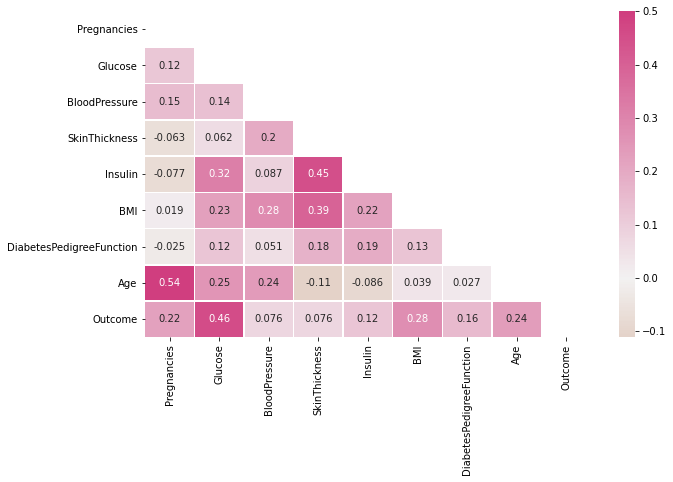

In [611]:
plt.figure(figsize = (10,6))
sns.heatmap(data.corr(), mask = np.triu(np.ones_like(data.corr(), dtype=bool)), cmap = sns.diverging_palette(30, 350, as_cmap=True), annot=True, vmax=.5, center=0, linewidths=.5);

Come ci aspettavamo infatti la variabile maggiormente correlata con la presenza del diabete è la concentrazione di glucosio. 

E' possibile notare come anche l'indice di massa corporea e l'età abbiano una notevole importanza, mentre variabili quali Pressione sanguigna e Spessore della pelle sono praticamente irrilevanti.


## Standardizzazione ed individuazione delle feature più rilevanti

Per prima cosa importiamo le librerie che ci serviranno in questa parte.

In [612]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold

Selezioniamo i dati su cui lavorare e li suddividiamo in un training set ed in un validation set con la funzione *train_test_split*

In [613]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,             # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

Procediamo quindi addestrando un modello di classificazione automatico.

Partiamo da un modello *Perceptron*, un algoritmo di apprendimento molto semplice, concettualmente simile alla discesa gradiente.

In questo modo, date  $n$ variabili $x_1,\ldots,x_n$, è possibile individuare un iperpiano di classificazione descritto dall'equazione:
$$ w_1\cdot x_1+\ldots+w_n\cdot x_n+b = 0 $$

o in forma vettoriale: $$ \mathbf{w}\cdot\mathbf{x}+b = 0 $$
avente valori ottimali per il vettore $\mathbf{w}$ (_weights_, pesi) e per il termine $b$ (_bias_, distanza dell'iperpiano dall'origine).

In [614]:
model = Pipeline([
    ("model",  Perceptron(random_state=42))
])

Addestriamo il modello  appena creato  sul training set e visualizziamone l'**accuratezza**, ovvero la percentuale di osservazioni del validation set di cui il modello predice correttamente la classe. Questo modello classifica correttamente circa il 67% di istanze del training set e circa il 65% delle istanze del validation set. Tale valore può essere sicuramente migliorato.

In [615]:
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.6789197299324832

In [616]:
model.score(X_val, y_val)

0.6596701649175413

Possiamo trovare i valori dei pesi  **w**  e del bias  **b**  rispettivamente negli attributi coef_[0] e intercept_[0]

In [617]:
pd.Series(model.named_steps["model"].coef_[0], index= X_train.columns)

Pregnancies                 1272.000
Glucose                      232.000
BloodPressure               -409.000
SkinThickness               -128.000
Insulin                     -155.000
BMI                          -18.400
DiabetesPedigreeFunction      38.973
Age                         -211.000
dtype: float64

In [618]:
print("b: {:.5}".format(model.named_steps["model"].intercept_[0]))

b: -509.0


Di seguito è invece riportata la matrice di confusione di questo modello, dalla quale è possibile notare come sia presente un numero molto elevato di falsi negativi.

In [619]:
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=model.named_steps["model"].classes_, columns=model.named_steps["model"].classes_)

,0,1
0,388,47
1,180,52


Per migliorare il modello proviamo ad effettuare la **standardizzazione** dei dati.

In [620]:
std_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  Perceptron())
])
std_model.fit(X_train, y_train)
std_model.score(X_train, y_train)


0.7321830457614403

In [621]:
std_model.score(X_val, y_val)

0.7076461769115442

La standardizzazione ha portato ad un miglioramento dell'accuratezza del modello, che ora classifica correttamente circa il 70% delle istanze del validation set. 

Nella precedente fase di analisi esplorativa dei dati, osservando la matrice di correlazione, avevamo notato come alcune feature erano scarsamente correlate con la presenza della malattia nel paziente. 

Per questo motivo proviamo ad aggiungere la **regolarizzazione con norma L1** per individuare le variabili più rilevanti.

In [622]:
std_l1_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  Perceptron(penalty="l1"))
])

std_l1_model.fit(X_train, y_train)
std_l1_model.score(X_val, y_val)

0.7976011994002998

In [623]:
std_l1_model.score(X_train, y_train)

0.7456864216054013

In [624]:
pd.Series(std_l1_model.named_steps["model"].coef_[0], index= X_train.columns)

Pregnancies                 1.039743
Glucose                     2.178262
BloodPressure               0.000000
SkinThickness               0.000000
Insulin                     0.000000
BMI                         1.446835
DiabetesPedigreeFunction    2.481410
Age                         0.000000
dtype: float64

Questo modello non solo risulta essere il più accurato, con un accuratezza dell'80% (15% più accurato rispetto al primo modello individuato) ma consente anche di comprendere quali siano le variabili più rilevanti.

La concentrazione di glucosio si conferma infatti una feature molto rilevante, mentre, come avevamo già notato, variabili quali Pressione sanguigna e Spessore della pelle sono irrilevanti.

Proviamo quindi a creare un nuovo DataFrame in cui vengono escluse le feature *BloodPressure* e *SkinThickness* in quanto sia nell'ultimo modello che secondo la matrice di correlazione erano tra le variabili meno rilevanti.



In [625]:
data_mod = data[['Pregnancies','Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']]
data_mod.head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,0,33.6,0.127,47,1
1,0,84,125,38.2,0.233,23,0
2,0,145,0,44.2,0.630,31,1
3,0,135,250,42.3,0.365,24,1
4,1,139,480,40.7,0.536,21,0


Selezioniamo i nuovi dati su cui lavorare e li suddividiamo in un training set ed in un validation set.

Testiamo quindi i modelli *model* e *std_model* con i nuovi valori.

Osserviamo che anche se con *model* si ha un piccolo aumento di accuratezza, con *std_model* questa diminuisce notevolemente. 

I modelli di learning generati successivamente si baseranno per questo su tutte le feature del dataset.

In [626]:
X2 = data_mod.drop(["Outcome"], axis=1)
y2 = data_mod["Outcome"]

X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=1/3, random_state=42)

In [627]:
model.fit(X_train2, y_train2)
model.score(X_val2, y_val2)

0.6611694152923538

In [628]:
std_model.fit(X_train2, y_train2)
std_model.score(X_val2, y_val2)

0.5847076461769115

## Modellazione

Per prima cosa importiamo le librerie che ci serviranno in questa parte.

In [629]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import math
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from sklearn.metrics import classification_report, mean_squared_error
from statsmodels.stats.proportion import proportion_confint
from sklearn.ensemble import RandomForestClassifier

Tramite Grid Search e Stratified-K-fold cross validation generiamo modelli differenti in grado di stimare il valore migliore per gli iperparametri e per ognuno di essi ne calcoliamo l'accuratezza.

Creiamo sia uno splitter StratifiedKFold che garantisce uguale distribuzione delle classi tra un fold e l'altro.

In [630]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)
for train, val in skf.split(X_train, y_train):
    print(y_train.iloc[val].value_counts())

0    294
1    151
Name: Outcome, dtype: int64
0    293
1    151
Name: Outcome, dtype: int64
0    294
1    150
Name: Outcome, dtype: int64


Definiamo quindi una funzione *grid_search_with_stratifiedKFold* che, dato un modello, una "griglia" con liste di valori possibili per gli iperparametri di un modello e uno splitter StratifiedKFold, testi tutte le combinazioni possibili. Al termine visualizza l'accuratezza sul validation set, i miglior parametri individuati ed effettua una valutazione del modello a regime con calcolo degli intervalli di confidenza predittivi fissata la confidenza passata in input.

In [631]:
def grid_search_with_stratifiedKFold(model, grid, skf, dataset, confidence):
    grid_search = GridSearchCV(model, grid, cv=skf, n_jobs=-1)

    X_train, X_val, y_train, y_val = train_test_split(
        dataset.drop(["Outcome"], axis=1),
        dataset["Outcome"],
        test_size=1/3, random_state=42
    )

    grid_search.fit(X_train, y_train)
    
    score = grid_search.score(X_val, y_val)

    lower, upper = proportion_confint(len(X_train) * score, len(X_train), 1-confidence/100, method='wilson')

    print("Accuracy on validation set: {}\n".format(score))
    print("Best cross validation score: {}\n".format(grid_search.best_score_))
    print("Best params: {}\n".format(grid_search.best_params_))
    print("Best estimator: {}\n".format(grid_search.best_estimator_))
    print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower*100, upper*100))

    return grid_search, score

In [632]:
confidence = 95

In [633]:
models = {}

###**Perceptron**

Viene implementato nuovamente un modello *Perceptron* per valutare il punteggio che otterrebbe ottimizzando gli iperparametri e con una cross-fold validation.

In [634]:
perceptron_model = Pipeline([
    ("scaler", StandardScaler()),
    ("perceptron", Perceptron(n_jobs=-1, random_state=42))
])

perceptron_grid = {
    "scaler": [None, StandardScaler()],
    "perceptron__penalty": ["l2", "l1", "elasticnet"],
    'perceptron__alpha': [0.0001, 0.001, 0.01, 1]
}

perceptron_gs, perceptron_score = grid_search_with_stratifiedKFold(perceptron_model, perceptron_grid, skf, data, confidence)

Accuracy on validation set: 0.7421289355322339

Best cross validation score: 0.7171491716435536

Best params: {'perceptron__alpha': 0.0001, 'perceptron__penalty': 'l1', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('perceptron',
                 Perceptron(alpha=0.0001, class_weight=None,
                            early_stopping=False, eta0=1.0, fit_intercept=True,
                            max_iter=1000, n_iter_no_change=5, n_jobs=-1,
                            penalty='l1', random_state=42, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False))],
         verbose=False)

Interval with confidence 95%: 
Pmin = 71.7973%
Pmax = 76.4894%


In [635]:
perceptron_pred = perceptron_gs.predict(X_val)
print(classification_report(y_val, perceptron_pred))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       435
           1       0.61      0.73      0.66       232

    accuracy                           0.74       667
   macro avg       0.72      0.74      0.73       667
weighted avg       0.76      0.74      0.75       667



In [636]:
cm = confusion_matrix(y_val, perceptron_pred)
pd.DataFrame(cm, index=model.named_steps["model"].classes_, columns=model.named_steps["model"].classes_)

,0,1
0,326,109
1,63,169


In [637]:
perceptron_mse = mean_squared_error(y_val, perceptron_pred)
print('MSE: {}'.format(perceptron_mse))

MSE: 0.25787106446776614


In [638]:
models["Perceptron"] = {"F1_Measure" : f1_score(y_val, perceptron_pred, average="macro"), "Score" : perceptron_score}

### **Perceptron with Polynomial features**

Si implementa un modello *Perceptron* introducendo features polinomiali

In [639]:
from sklearn.preprocessing import PolynomialFeatures

poly_perceptron_model = Pipeline([
    ('std', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('perceptron', Perceptron(n_jobs=-1, random_state=42))
])

poly_perceptron_grid = {
    'std': [None, StandardScaler()],
    'perceptron__penalty': ['l1', 'l2', "elasticnet"],
    'perceptron__alpha': [0.0001, 0.001, 0.01, 0.1],
}

poly_perceptron_gs, poly_perceptron_score= grid_search_with_stratifiedKFold(poly_perceptron_model, poly_perceptron_grid, skf, data, confidence)

Accuracy on validation set: 0.760119940029985

Best cross validation score: 0.7291696190572595

Best params: {'perceptron__alpha': 0.0001, 'perceptron__penalty': 'l1', 'std': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best estimator: Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('perceptron',
                 Perceptron(alpha=0.0001, class_weight=None,
                            early_stopping=False, eta0=1.0, fit_intercept=True,
                            max_iter=1000, n_iter_no_change=5, n_jobs=-1,
                            penalty='l1', random_state=42, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False))],
         verbose=False

In [640]:
poly_perceptron_pred = poly_perceptron_gs.predict(X_val)
print(classification_report(y_val, poly_perceptron_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       435
           1       0.66      0.66      0.66       232

    accuracy                           0.76       667
   macro avg       0.74      0.74      0.74       667
weighted avg       0.76      0.76      0.76       667



In [641]:
cm = confusion_matrix(y_val, poly_perceptron_pred)
pd.DataFrame(cm, index=model.named_steps["model"].classes_, columns=model.named_steps["model"].classes_)

,0,1
0,355,80
1,80,152


In [642]:
poly_perceptron_mse = mean_squared_error(y_val, poly_perceptron_pred)
print('MSE: {}'.format(poly_perceptron_mse))

MSE: 0.239880059970015


In [643]:
models["Poly_Perceptron"] = {"F1_Measure" : f1_score(y_val, poly_perceptron_pred, average="macro"), "Score" : poly_perceptron_score}

###**Logistic Regression**

La regressione _logistica_ è un modello di classificazione binaria basato sulla regressione lineare.
Si può decidere:
  - standardizzazione dei dati
  - regolarizzazione di tipo "l2", "l1" o "elasticnet"
  - parametro C pari a 0.001, 0.01, 0.1, 1
  - nel caso di "elasticnet", `l1_ratio` pari a 0.2 o 0.5

In [644]:
log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver='saga', random_state=42))
])

#print(log_model.get_params())

log_grid = {
    "scaler": [None, StandardScaler()],
    "lr__penalty": ["l2", "l1"],
    "lr__C": [0.001, 0.01, 0.1, 1],
    "lr__fit_intercept": [False, True]
}

log_grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__C": [0.001, 0.01, 0.1, 1],
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": [0.001, 0.01, 0.1, 1],
        "lr__l1_ratio": [0.2, 0.5],
    }
]

log_gs, log_score= grid_search_with_stratifiedKFold(log_model, log_grid, skf, data, confidence)

Accuracy on validation set: 0.7976011994002998

Best cross validation score: 0.7621621621621623

Best params: {'lr__C': 1, 'lr__penalty': 'l2', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Interval with confidence 95%: 
Pmin = 77.5191%
Pmax = 81.8301%


In [645]:
log_pred = log_gs.predict(X_val)
print(classification_report(y_val, log_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       435
           1       0.76      0.61      0.68       232

    accuracy                           0.80       667
   macro avg       0.79      0.75      0.77       667
weighted avg       0.79      0.80      0.79       667



In [646]:
cm = confusion_matrix(y_val, log_pred)
pd.DataFrame(cm, index=model.named_steps["model"].classes_, columns=model.named_steps["model"].classes_)

,0,1
0,390,45
1,90,142


In [647]:
log_mse = mean_squared_error(y_val, log_pred)
print('MSE: {}'.format(log_mse))

MSE: 0.20239880059970014


In [648]:
models["Logistic_Regression"] = {"F1_Measure" : f1_score(y_val, log_pred, average="macro"), "Score" : log_score}

###**SVM**

Il metodo delle Support Vector Machines (SVM) è stato formulato proprio per la classificazione binaria in quanto consiste nell'individuare un iperpiano di separazione ottimale tra le due classi basandosi sulle istanze più vicine ad esso, i cosiddetti _support vector_.

In [649]:
%%time
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=42))
])

#print(svm_model.get_params())

svm_grid = [
  {'svc__C': [0.01, 0.1, 1, 10], 'svc__kernel': ['linear']},
  {'svc__C': [0.01, 0.1, 1, 10], 'svc__kernel': ['poly']},
  {'svc__C': [0.01, 0.1, 1, 10], 'svc__kernel': ['rbf']}
]

svm_gs, svm_score = grid_search_with_stratifiedKFold(svm_model, svm_grid, skf, data, confidence)

Accuracy on validation set: 0.8830584707646177

Best cross validation score: 0.8416911293315787

Best params: {'svc__C': 10, 'svc__kernel': 'rbf'}

Best estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=42, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

Interval with confidence 95%: 
Pmin = 86.4696%
Pmax = 89.9219%
CPU times: user 204 ms, sys: 6.56 ms, total: 210 ms
Wall time: 1.35 s


In [650]:
svm_pred = svm_gs.predict(X_val)
print(classification_report(y_val, svm_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       435
           1       0.86      0.79      0.82       232

    accuracy                           0.88       667
   macro avg       0.88      0.86      0.87       667
weighted avg       0.88      0.88      0.88       667



In [651]:
cm = confusion_matrix(y_val, svm_pred)
pd.DataFrame(cm, index=model.named_steps["model"].classes_, columns=model.named_steps["model"].classes_)

,0,1
0,406,29
1,49,183


In [652]:
svm_mse = mean_squared_error(y_val, svm_pred)
print('MSE: {}'.format(svm_mse))

MSE: 0.11694152923538231


In [653]:
models["SVM"] = {"F1_Measure" : f1_score(y_val, svm_pred, average="macro"), "Score" : svm_score}

### **Decision Tree**


Gli alberi decisionali, a differenza dei modelli precedentemente implementati che si basano su iperpiani descritti da equazioni su tutte le variabili, costituiscono un approccio differente: la classificazione avviene in base ad una serie di decisioni "semplici", basate ciascuna su una sola variabile, ciascuna delle quali porta ad un ramo diverso dell'albero.

In [654]:
%%time
decision_tree_model = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier(random_state=42))
])

decision_tree_grid = {"scaler": [None, StandardScaler()],
             'tree__min_samples_split': [2, 5, 10],
             'tree__min_samples_leaf': [None, 1, 2], 
             'tree__max_depth': [6, 8, 10]}

decision_tree_model_gs, decision_tree_score = grid_search_with_stratifiedKFold(decision_tree_model, decision_tree_grid, skf, data, confidence)

Accuracy on validation set: 0.9250374812593704

Best cross validation score: 0.8784509228329452

Best params: {'scaler': None, 'tree__max_depth': 10, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}

Best estimator: Pipeline(memory=None,
         steps=[('scaler', None),
                ('tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=10,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=42,
                                        splitter='best'))],
         verbose=False)

Interval with confid

In [655]:
dt_pred = decision_tree_model_gs.predict(X_val)
print(classification_report(y_val, dt_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       435
           1       0.90      0.88      0.89       232

    accuracy                           0.93       667
   macro avg       0.92      0.92      0.92       667
weighted avg       0.92      0.93      0.92       667



In [656]:
cm = confusion_matrix(y_val, dt_pred)
pd.DataFrame(cm, index=model.named_steps["model"].classes_, columns=model.named_steps["model"].classes_)

,0,1
0,412,23
1,27,205


In [657]:
dt_mse = mean_squared_error(y_val, dt_pred)
print('MSE: {}'.format(dt_mse))

MSE: 0.07496251874062969


In [658]:
models["Decision_Tree"] = {"F1_Measure" : f1_score(y_val, dt_pred, average="macro"), "Score" : decision_tree_score}

###**Random Forest**

Random Forest è un classificatore che fa uso di un insieme di alberi decisionali su sottoinsiemi di variabili di input. Questa tecnica generalmente tende a diminuire il tipico overfitting dei singoli alberi decisionali.

In [659]:
%%time
forest_model = Pipeline([
    ("scaler", StandardScaler()),
    ("forest", RandomForestClassifier(n_jobs=-1, random_state=42))
])

forest_grid = {"scaler": [None, StandardScaler()],
            'forest__n_estimators': [10, 50, 100],
            'forest__max_depth': [6, 8, 10],
            'forest__min_samples_leaf': [None, 1, 2],
            'forest__min_samples_split': [2, 5, 10]}

forest_model_gs, forest_score = grid_search_with_stratifiedKFold(forest_model, forest_grid, skf, data, confidence)

Accuracy on validation set: 0.9505247376311844

Best cross validation score: 0.9032088268043325

Best params: {'forest__max_depth': 10, 'forest__min_samples_leaf': 1, 'forest__min_samples_split': 2, 'forest__n_estimators': 100, 'scaler': None}

Best estimator: Pipeline(memory=None,
         steps=[('scaler', None),
                ('forest',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
  

In [660]:
forest_pred = forest_model_gs.predict(X_val)
print(classification_report(y_val, forest_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       435
           1       0.93      0.92      0.93       232

    accuracy                           0.95       667
   macro avg       0.95      0.94      0.95       667
weighted avg       0.95      0.95      0.95       667



In [661]:
cm = confusion_matrix(y_val, forest_pred)
pd.DataFrame(cm, index=model.named_steps["model"].classes_, columns=model.named_steps["model"].classes_)

,0,1
0,420,15
1,18,214


In [662]:
forest_mse = mean_squared_error(y_val, forest_pred)
print('MSE: {}'.format(forest_mse))

MSE: 0.049475262368815595


In [663]:
models["Random_Forest"] = {"F1_Measure" : f1_score(y_val, forest_pred, average="macro"), "Score" : forest_score}

## Confronto tra i modelli e scelta dei migliori

Per il confronto conclusivo tra i vari modelli si riportano di seguito i valori di F1 calcolati nella fase precedente e l'accuratezza sul validation set. Successivamente si rappresenta su un grafico a barre i valori di F1 per meglio notare le differenze tra i diversi modelli implementati.

In [664]:
reports = pd.DataFrame.from_dict(models)
reports = reports.transpose()
reports.sort_values(by=["F1_Measure"], inplace=True)
reports

,F1_Measure,Score
Perceptron,0.727004,0.742129
Poly_Perceptron,0.735632,0.760120
Logistic_Regression,0.765132,0.797601
SVM,0.868342,0.883058
Decision_Tree,0.917048,0.925037
Random_Forest,0.945308,0.950525


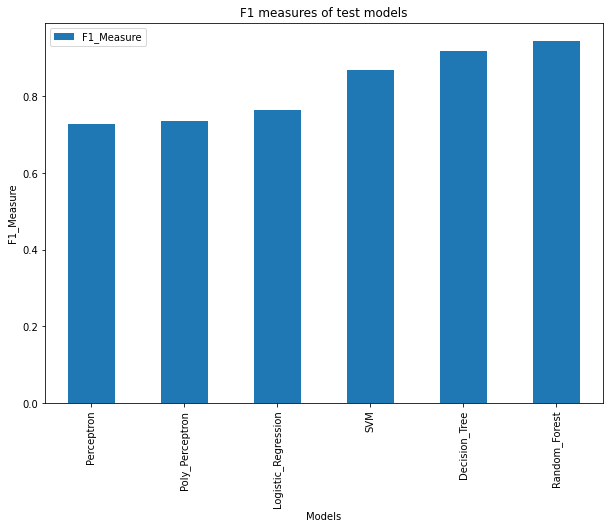

In [665]:
axes = reports.plot.bar(y="F1_Measure", xlabel="Models", ylabel="F1_Measure", title="F1 measures of test models", figsize=(10,7))


Dopo un'attenta analisi dei risultati ottenuti, tenendo conto anche  dell'intervallo di confidenza individuato per ogni modello nella fase precedente, è possibile individuare tre modelli che riescono ad approssimare più efficacemente il problema. Questi sono SVM, Decision_Tree e Random_Forest. In linea di massima si osserva come i modelli più complessi riescono ad ottenere risultati migliori su questo problema. Probabilmente i modelli più semplici come ad esempio Perceptron non riescono ad ottenere un'approssimazione efficace del problema.

Per confrontare ulteriormente i 3 modelli selezionati, definiamo la seguente funzione che permette di confrontare due modelli per valutare se la differenza tra di essi sia statisticamente significativa o meno.

In [666]:
def model_comparison(mse_1, mse_2):
    d = np.abs(mse_1 - mse_2)
    variance = (mse_1 * (1 - mse_1)) / len(X_val) + (mse_2 * (1 - mse_2)) / len(X_val)
    d_min = d - 1.96 * np.sqrt(variance)
    d_max = d + 1.96 * np.sqrt(variance)
    return (d_min, d_max)

Confronto tra **Decision Tree** e **Random Forest**

In questo caso, poichè l'intervallo restituito contiene lo 0, la differenza è solo frutto del caso.

In [667]:
print('Interval {}'.format(np.round(model_comparison(dt_mse, forest_mse), 4)))

Interval [-0.0004  0.0514]


Confronto tra **Decision Tree** e **SVM**

In questo caso invece la differenza è significativa: l'intervallo restituito NON contiene lo 0.

In [668]:
print('Interval {}'.format(np.round(model_comparison(svm_mse, dt_mse), 4)))

Interval [0.0104 0.0735]


Dovendo scegliere un modello migliore e ragionando in termini di efficienza la scelta ricade quindi sul **Decision Tree**. Questo modello permette infatti di ottenere ottimi risultati, con il vantaggio di un tempo di esecuzione ed una complessita inferiori rispetto a *Random Forest*, al quale risulta equivalente.

**Interpretazione della conoscenza appresa dal modello**

Uno dei vantaggi degli alberi decisionali è che spesso sono più facilmente interpretabili da una persona rispetto ad un insieme di coefficienti numerici.


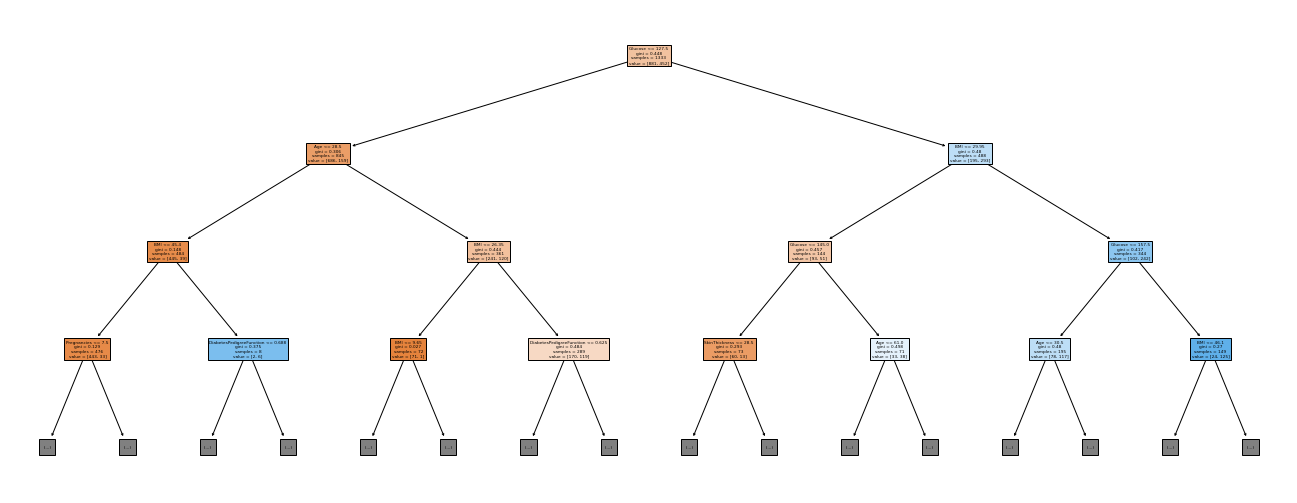

In [669]:
from sklearn.tree import plot_tree
plt.figure(figsize=(23, 9))
plot_tree(decision_tree_model_gs.best_estimator_[1], feature_names=X.columns, max_depth=3, filled=True);

In [670]:
vars = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

In [671]:
from sklearn.tree import export_text
print(export_text(decision_tree_model_gs.best_estimator_[1], feature_names=vars, max_depth=5,))

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 45.40
|   |   |   |--- Pregnancies <= 7.50
|   |   |   |   |--- BMI <= 31.40
|   |   |   |   |   |--- DiabetesPedigreeFunction <= 0.67
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- DiabetesPedigreeFunction >  0.67
|   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |--- BMI >  31.40
|   |   |   |   |   |--- DiabetesPedigreeFunction <= 0.96
|   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |--- DiabetesPedigreeFunction >  0.96
|   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- Pregnancies >  7.50
|   |   |   |   |--- class: 1
|   |   |--- BMI >  45.40
|   |   |   |--- DiabetesPedigreeFunction <= 0.69
|   |   |   |   |--- class: 1
|   |   |   |--- DiabetesPedigreeFunction >  0.69
|   |   |   |   |--- class: 0
|   |--- Age >  28.50
|   |   |--- BMI <= 26.35
|   |   |   |--- BMI <= 9.65
|   |   |   |   |--- class: 1
|   |   |   |--- BMI > 

La rappresentazione dell'albero decisionale mostra infatti intuitivamente come il modello proceda con la classificazione:

- Per prima cosa, considera la **concentrazione di glucosio** (`Glucose`)
  - se **<= 127.50**, considera l'**età** (`Age`)
  - altrimenti, se > 127.50, considera il **BMI** del paziente (`BMI`)

E continua analogamente, con split successivi, fino che non è in grado di classificare.



Osserviamo quindi le features che hanno contribuito maggiormente nella predizione.

In [672]:
decision_tree_imp = pd.Series(decision_tree_model_gs.best_estimator_[1].feature_importances_, index=X_train.columns).sort_values(ascending=False)
decision_tree_imp

Glucose                     0.299380
BMI                         0.194623
Age                         0.126056
DiabetesPedigreeFunction    0.119056
BloodPressure               0.096836
Pregnancies                 0.076947
Insulin                     0.056743
SkinThickness               0.030359
dtype: float64

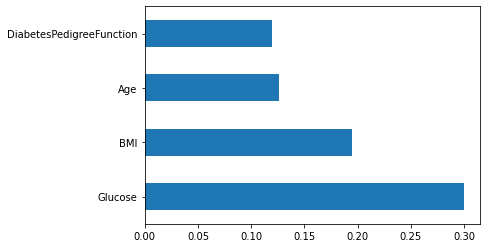

In [673]:
decision_tree_imp.head(4).plot(kind='barh')

Coerentemente con quanto ci aspettavamo, la variabile maggiormente correlata con la presenza del diabete è la concentrazione di glucosio. 

Anche l'indice di massa corporea, l'età e la funzione che valuta la probabilità di diabete in base alla storia familiare hanno una notevole importanza, mentre variabili quali Insulina e Spessore della pelle sono praticamente irrilevanti.

In conclusione, è possibile affermare che si è riuscito ad estrarre un modello di classificazione che consente di predire la presenza del diabete in un paziente con buona precisione e coerente con la realtà.